In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.learning_curve import learning_curve
from sklearn import metrics, cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,log_loss, f1_score
from sklearn.grid_search import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing cleaned dataset for both the testing set and training set 
trainDF = pd.read_csv('files/cleanTrain.csv')
testDF = pd.read_csv('files/cleanTest.csv')

In [3]:
trainDF.head()

,AnimalID,Name,OutcomeType,AnimalType,AgeuponOutcome,Breed,Color,Sex,Neutered,Year,Month,Day,Hour,Minute
0,A671945,Has Name,Return_to_owner,Dog,52,Hybrid,Brown,Male,Neutered,2014,2,12,18,22
1,A656520,Has Name,Euthanasia,Cat,52,Hybrid,Cream,Female,Neutered,2013,10,13,12,44
2,A686464,Has Name,Adoption,Dog,104,Hybrid,Blue,Male,Neutered,2015,1,31,12,28
3,A683430,No Name,Transfer,Cat,3,Hybrid,Blue,Male,Intact,2014,7,11,19,9
4,A667013,No Name,Transfer,Dog,104,Hybrid,Tan,Male,Neutered,2013,11,15,12,52


In [4]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 14 columns):
AnimalID          26729 non-null object
Name              26729 non-null object
OutcomeType       26729 non-null object
AnimalType        26729 non-null object
AgeuponOutcome    26729 non-null int64
Breed             26729 non-null object
Color             26729 non-null object
Sex               26729 non-null object
Neutered          26729 non-null object
Year              26729 non-null int64
Month             26729 non-null int64
Day               26729 non-null int64
Hour              26729 non-null int64
Minute            26729 non-null int64
dtypes: int64(6), object(8)
memory usage: 2.9+ MB


In [5]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 13 columns):
ID                11456 non-null int64
Name              11456 non-null object
AnimalType        11456 non-null object
AgeuponOutcome    11456 non-null int64
Breed             11456 non-null object
Color             11456 non-null object
Sex               11456 non-null object
Neutered          11456 non-null object
Year              11456 non-null int64
Month             11456 non-null int64
Day               11456 non-null int64
Hour              11456 non-null int64
Minute            11456 non-null int64
dtypes: int64(7), object(6)
memory usage: 1.1+ MB


In [6]:
# Dropping features so that datasets features match
train = trainDF.drop(['AnimalID', 'OutcomeType'], axis = 1)
test = testDF.drop('ID', axis=1)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 12 columns):
Name              26729 non-null object
AnimalType        26729 non-null object
AgeuponOutcome    26729 non-null int64
Breed             26729 non-null object
Color             26729 non-null object
Sex               26729 non-null object
Neutered          26729 non-null object
Year              26729 non-null int64
Month             26729 non-null int64
Day               26729 non-null int64
Hour              26729 non-null int64
Minute            26729 non-null int64
dtypes: int64(6), object(6)
memory usage: 2.4+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 12 columns):
Name              11456 non-null object
AnimalType        11456 non-null object
AgeuponOutcome    11456 non-null int64
Breed             11456 non-null object
Color             11456 non-null object
Sex               11456 non-null object
Neutered          11456 non-null object
Year              11456 non-null int64
Month             11456 non-null int64
Day               11456 non-null int64
Hour              11456 non-null int64
Minute            11456 non-null int64
dtypes: int64(6), object(6)
memory usage: 1.0+ MB


In [9]:
# Transform data into numeric values
lb = LabelEncoder()
categorical_columns = train.columns[train.dtypes == 'object']
for var in categorical_columns:
    full_data = pd.concat((train[var],test[var]),axis=0).astype('str')
    lb.fit(full_data )
    train.loc[:, var] = lb.transform(train[var].astype('str'))
    test.loc[:, var] = lb.transform(test[var].astype('str'))

In [10]:
train.head()

,Name,AnimalType,AgeuponOutcome,Breed,Color,Sex,Neutered,Year,Month,Day,Hour,Minute
0,0,1,52,0,4,1,1,2014,2,12,18,22
1,0,0,52,0,8,0,1,2013,10,13,12,44
2,0,1,104,0,3,1,1,2015,1,31,12,28
3,1,0,3,0,3,1,0,2014,7,11,19,9
4,1,1,104,0,23,1,1,2013,11,15,12,52


In [11]:
#
X_all = train.values
y_all = trainDF.OutcomeType.values

x_test = test.values

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all,
                                                                     test_size=0.30, random_state=67) 

In [13]:
def train_classifier(clf, X_train, y_train):
    print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print("Done!\nTraining time (secs): {:.3f}".format(end - start))
    
def predict_labels(clf, X_train, y_train):
    print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(X_train)
    end = time.time()
    print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return cross_val_score(clf, X_train, y_train, scoring= 'log_loss')

def train_predict(clf, X_train, y_train, X_test, y_test):
    print ("------------------------------------------")
    print ("Training set size: {}".format(len(X_train)))
    train_classifier(clf, X_train, y_train)
    print ("Log_loss score for training set: {}".format(predict_labels(clf, X_train, y_train)))
    print ("Log_loss for test set: {}".format(predict_labels(clf, X_test, y_test)))

In [14]:
# Loading the classifiers that will be used
clf = GaussianNB()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
log = LogisticRegression()

In [15]:
# The training of each model
train_predict(clf, X_train, y_train, X_test, y_test)
train_predict(rfc, X_train, y_train, X_test, y_test)
train_predict(gbc, X_train, y_train, X_test, y_test)
train_predict(knn, X_train, y_train, X_test, y_test)
train_predict(log, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 18710
Training GaussianNB...
Done!
Training time (secs): 0.030
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.010
Log_loss score for training set: [-1.35270304 -1.4415109  -1.40703546]
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.003
Log_loss for test set: [-1.42382185 -1.46435222 -1.43835775]
------------------------------------------
Training set size: 18710
Training RandomForestClassifier...
Done!
Training time (secs): 0.153
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.032
Log_loss score for training set: [-2.41198628 -2.38021439 -2.38205011]
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.014
Log_loss for test set: [-2.63771628 -2.41418837 -2.59158144]
------------------------------------------
Training set size: 18710
Training GradientBoostingClassifier...
Done!
Training time (secs): 5.432
Predicting la

In [16]:
param_test1 = {'n_estimators':[i for i in range(90, 100)]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.78106, std: 0.01022, params: {'n_estimators': 90},
  mean: -0.78084, std: 0.01025, params: {'n_estimators': 91},
  mean: -0.78084, std: 0.01029, params: {'n_estimators': 92},
  mean: -0.78075, std: 0.01029, params: {'n_estimators': 93},
  mean: -0.78075, std: 0.01040, params: {'n_estimators': 94},
  mean: -0.78082, std: 0.01050, params: {'n_estimators': 95},
  mean: -0.78096, std: 0.01061, params: {'n_estimators': 96},
  mean: -0.78101, std: 0.01065, params: {'n_estimators': 97},
  mean: -0.78119, std: 0.01069, params: {'n_estimators': 98},
  mean: -0.78101, std: 0.01043, params: {'n_estimators': 99}],
 {'n_estimators': 93},
 -0.78075015606863474)

In [17]:
param_test2 = {'max_depth':[i for i in range(5,16,2)], 'min_samples_split': [i for i in range(200,1001,200)]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt',
                        subsample=0.8,random_state=10,n_estimators=93), param_grid = param_test2, scoring='log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.78379, std: 0.00757, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: -0.78455, std: 0.00667, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: -0.78500, std: 0.00648, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: -0.78727, std: 0.00697, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: -0.78841, std: 0.00763, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: -0.77767, std: 0.00769, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: -0.77893, std: 0.00709, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: -0.78078, std: 0.00829, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: -0.78291, std: 0.00675, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: -0.78504, std: 0.00771, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: -0.78093, std: 0.00866, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: -0.77857, std: 0.00924, params: {'max_depth': 9, 'min_samples_spli

In [18]:
param_test3 = {'min_samples_leaf':[i for i in range(30,71,10)], 'min_samples_split': [i for i in range(10,200, 10)]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_features='sqrt',max_depth=7,
                        subsample=0.8,random_state=10,n_estimators=93), param_grid = param_test3, scoring='log_loss',
                        n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 10},
  mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 20},
  mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 30},
  mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 40},
  mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 50},
  mean: -0.77765, std: 0.00906, params: {'min_samples_leaf': 30, 'min_samples_split': 60},
  mean: -0.77809, std: 0.00862, params: {'min_samples_leaf': 30, 'min_samples_split': 70},
  mean: -0.77907, std: 0.01045, params: {'min_samples_leaf': 30, 'min_samples_split': 80},
  mean: -0.77695, std: 0.00736, params: {'min_samples_leaf': 30, 'min_samples_split': 90},
  mean: -0.77893, std: 0.00851, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: -0.77849, std: 0.00843, params: {'min_samples_leaf': 30, 'min_samples_split': 110

In [19]:
param_test5 = {'max_features':[i for i in range(1,12,2)]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_depth=7,
                        min_samples_leaf= 40, min_samples_split= 170,subsample=0.8,random_state=10,n_estimators=93),
                        param_grid = param_test5, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.79048, std: 0.00875, params: {'max_features': 1},
  mean: -0.77660, std: 0.00823, params: {'max_features': 3},
  mean: -0.77838, std: 0.00959, params: {'max_features': 5},
  mean: -0.77731, std: 0.00978, params: {'max_features': 7},
  mean: -0.77989, std: 0.00980, params: {'max_features': 9},
  mean: -0.78132, std: 0.00830, params: {'max_features': 11}],
 {'max_features': 3},
 -0.77659924698863203)

In [20]:
param_test6 = {'subsample':[i/100 for i in range(1,100,5)]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features=3,
                        min_samples_leaf= 40, min_samples_split= 170,random_state=10,n_estimators=93),
                        param_grid = param_test6, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -1.24534, std: 0.00051, params: {'subsample': 0.01},
  mean: -0.83444, std: 0.00641, params: {'subsample': 0.06},
  mean: -0.81686, std: 0.00757, params: {'subsample': 0.11},
  mean: -0.80639, std: 0.00795, params: {'subsample': 0.16},
  mean: -0.79972, std: 0.00815, params: {'subsample': 0.21},
  mean: -0.79753, std: 0.00668, params: {'subsample': 0.26},
  mean: -0.79292, std: 0.00821, params: {'subsample': 0.31},
  mean: -0.79076, std: 0.00899, params: {'subsample': 0.36},
  mean: -0.78663, std: 0.00910, params: {'subsample': 0.41},
  mean: -0.78841, std: 0.00942, params: {'subsample': 0.46},
  mean: -0.78625, std: 0.00791, params: {'subsample': 0.51},
  mean: -0.78356, std: 0.00669, params: {'subsample': 0.56},
  mean: -0.78310, std: 0.00796, params: {'subsample': 0.61},
  mean: -0.78109, std: 0.00833, params: {'subsample': 0.66},
  mean: -0.78016, std: 0.00787, params: {'subsample': 0.71},
  mean: -0.78006, std: 0.00931, params: {'subsample': 0.76},
  mean: -0.77981, std: 0

In [21]:
param_test6 = {'subsample':[i/100 for i in range(90,101)]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features=3,
                        min_samples_leaf= 40, min_samples_split= 170,random_state=10,n_estimators=93),
                        param_grid = param_test6, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.77643, std: 0.00779, params: {'subsample': 0.9},
  mean: -0.77678, std: 0.00932, params: {'subsample': 0.91},
  mean: -0.77670, std: 0.01035, params: {'subsample': 0.92},
  mean: -0.77649, std: 0.00906, params: {'subsample': 0.93},
  mean: -0.77531, std: 0.00839, params: {'subsample': 0.94},
  mean: -0.77584, std: 0.00825, params: {'subsample': 0.95},
  mean: -0.77473, std: 0.00849, params: {'subsample': 0.96},
  mean: -0.77743, std: 0.00866, params: {'subsample': 0.97},
  mean: -0.77644, std: 0.00928, params: {'subsample': 0.98},
  mean: -0.77546, std: 0.00874, params: {'subsample': 0.99},
  mean: -0.77663, std: 0.00858, params: {'subsample': 1.0}],
 {'subsample': 0.96},
 -0.77472947152079907)

In [22]:
# Determining the best tradeoff for the number of estimators and learning rat
clf2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features=3,
                        min_samples_leaf= 40, min_samples_split= 170,subsample=0.96,random_state=10,n_estimators=93)

In [23]:
clf3 = GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features=3,
                        min_samples_leaf= 40, min_samples_split= 170,subsample=0.96,random_state=10,n_estimators=186)

In [25]:
clf4 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=3,
                        min_samples_leaf= 40, min_samples_split= 170,subsample=0.96,random_state=10,n_estimators=700)

In [26]:
cross_val_score(clf2, X_all, y_all, cv = 3, scoring = 'log_loss')

array([-0.7745057 , -0.77154197, -0.76399355])

In [27]:
cross_val_score(clf3, X_all, y_all, cv = 3, scoring = 'log_loss')

array([-0.77050449, -0.76873177, -0.7588799 ])

In [28]:
cross_val_score(clf4, X_all, y_all, cv = 3, scoring = 'log_loss')

array([-0.77085097, -0.76916572, -0.76148864])

In [29]:
# Training best tuned model and preparing for submission to kaggle 
clf3.fit(X_all, y_all)
pred = clf3.predict_proba(x_test)

In [30]:
submission = pd.DataFrame(pred, columns=clf3.classes_)

In [31]:
submission['ID'] = testDF.ID

In [32]:
submission.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer,ID
0,0.024640,0.002442,0.023852,0.234030,0.715037,1
1,0.558466,0.000960,0.013343,0.364317,0.062913,2
2,0.582521,0.001366,0.011847,0.163104,0.241162,3
3,0.213671,0.002866,0.098542,0.136575,0.548346,4
4,0.377189,0.000678,0.010481,0.517588,0.094064,5


In [33]:
submission.to_csv('files/submission.csv', index=False)

 1) Name                           0.204833
 2) AnimalType                     0.149666
 3) AgeuponOutcome                 0.146718
 4) Breed                          0.119835
 5) Color                          0.087465
 6) Sex                            0.070075
 7) Neutered                       0.067479
 8) Year                           0.046675
 9) Month                          0.042494
10) Day                            0.040420
11) Hour                           0.014636
12) Minute                         0.009704


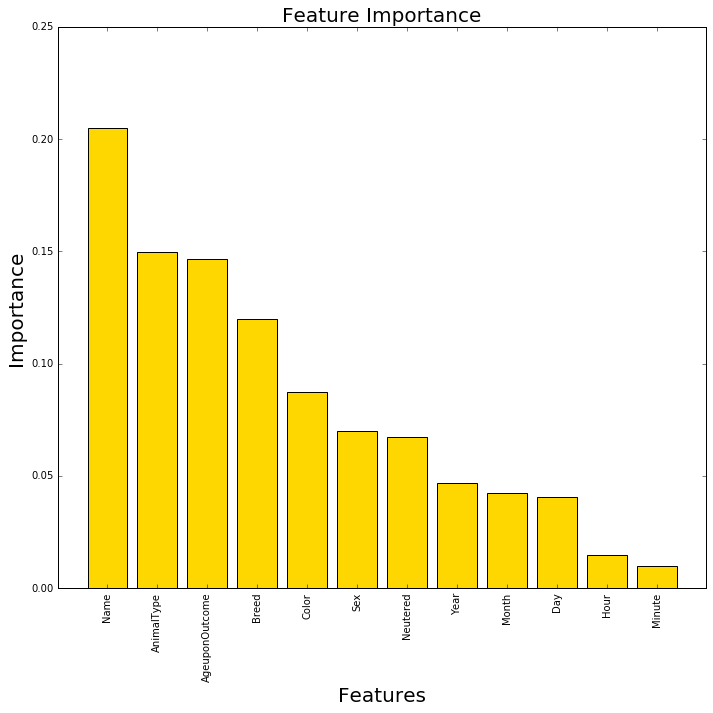

In [94]:
important = clf3.feature_importances_
indices = np.argsort(important)[::-1]
feat_labels = train.columns

for f in range(X_all.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], important[indices[f]]))
    
plt.figure(figsize=(10,10))    
plt.title('Feature Importance', fontsize=20)
plt.bar(range(X_all.shape[1]), important[indices],
       color='gold', align='center')
plt.xticks(range(X_all.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_all.shape[1]])
plt.xlabel('Features', fontsize=20)
plt.ylabel('Importance', fontsize=20)
plt.tight_layout()
plt.show
plt.savefig('images/featureImportance.png')

<function matplotlib.pyplot.show>

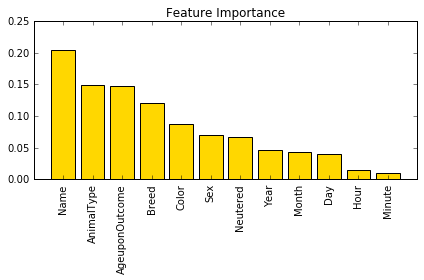

In [85]:
plt.title('Feature Importance')
plt.bar(range(X_all.shape[1]), important[indices],
       color='gold', align='center')
plt.xticks(range(X_all.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_all.shape[1]])
plt.tight_layout()
plt.show

In [81]:
train.shape[1]

12

In [83]:
train.columns

Index(['Name', 'AnimalType', 'AgeuponOutcome', 'Breed', 'Color', 'Sex',
       'Neutered', 'Year', 'Month', 'Day', 'Hour', 'Minute'],
      dtype='object')